In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/multilevel_modeling.xlsx")

In [4]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [5]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int64)

In [6]:
groups = df.groupby(df["id"])

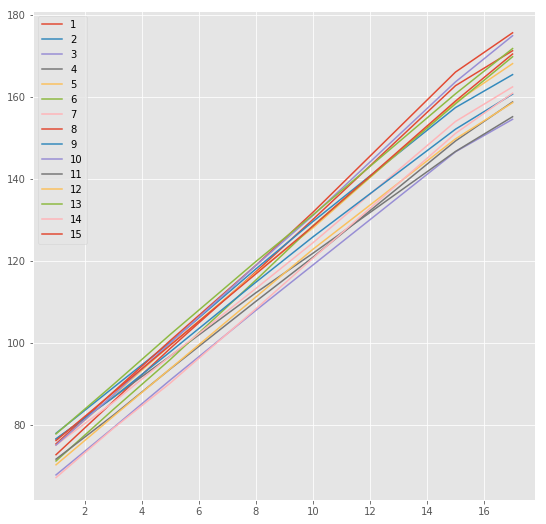

In [7]:
plt.figure(figsize=(9,9))
for name, group in groups:
    plt.plot(group["age"],group["height"],label=name)
plt.legend()

In [8]:
stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}

"""

In [9]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_086a333d9101221579c8f12b530c2084 NOW.


In [10]:
stan_data = {"N":df.shape[0], "N_id":15, "X":df["age"], "Y":df["height"], "s_id":df["id"]}

In [11]:
fit = sm.sampling(data = stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [12]:
fit

Inference for Stan model: anon_model_086a333d9101221579c8f12b530c2084.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  5.6e-3   0.12   5.53   5.69   5.77   5.85    6.0    441    1.0
b0        68.25    0.04   0.99  66.22  67.64  68.26  68.87  70.25    615    1.0
a_id[0]    0.47  5.6e-3   0.13   0.22   0.38   0.46   0.55   0.73    534    1.0
a_id[1]   -0.19  5.7e-3   0.13  -0.45  -0.28  -0.19   -0.1   0.07    538    1.0
a_id[2]   -0.29  5.5e-3   0.13  -0.55  -0.38  -0.29   -0.2  -0.03    573    1.0
a_id[3]    -0.8  6.2e-3   0.13  -1.06  -0.88   -0.8  -0.71  -0.54    441    1.0
a_id[4]    0.09  5.6e-3   0.13  -0.16-2.3e-4   0.09   0.17   0.35    540    1.0
a_id[5]    0.41  6.1e-3   0.13   0.15   0.32   0.41   0.49   0.68    460    1.0
a_id[6]   -0.21  5.6e-3   0.13  -0.47   -0.3  -0.21  -0.12   0.05    546    1.0
a_id[7]    

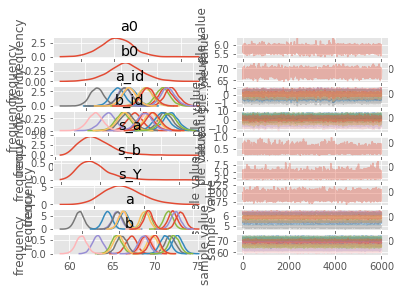

In [13]:
fig = fit.plot()

In [14]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [15]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:,0] * x[i] + ms_b[:,0]

In [16]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [17]:
df_0 = groups.get_group(1)

In [18]:
df_0.head()

,age,height
0,1,72.737927
1,3,85.694575
2,5,98.635829
3,8,117.302636
4,10,130.076144


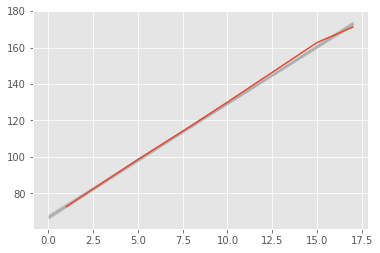

In [20]:
plt.plot(df_0["age"],df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")